## 1. Importing Modules and Accessing Data

In [1]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np

In [2]:
import zipfile
zip_ref = zipfile.ZipFile('/content/data.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [3]:
df = pd.read_csv(os.path.join('data','train.csv','train.csv'))

In [4]:
df

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0


In [5]:
df.iloc[12]['comment_text']

'Hey... what is it..\n@ | talk .\nWhat is it... an exclusive group of some WP TALIBANS...who are good at destroying, self-appointed purist who GANG UP any one who asks them questions abt their ANTI-SOCIAL and DESTRUCTIVE (non)-contribution at WP?\n\nAsk Sityush to clean up his behavior than issue me nonsensical warnings...'

In [6]:
df[df.columns[2:]].iloc[12]

toxic            1
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
Name: 12, dtype: int64

## 2. Preprocessing Data

In [7]:
from tensorflow.keras.layers import TextVectorization

In [8]:
x = df['comment_text']
y = df[df.columns[2:]].values

In [9]:
max_words = 200000 #number of words in vocab

In [10]:
vectorizer = TextVectorization(max_tokens=max_words , output_sequence_length=1800 , output_mode="int")

In [11]:
vectorizer.adapt(x.values)

In [12]:
vectorizer.get_vocabulary()

['',
 '[UNK]',
 'the',
 'to',
 'of',
 'and',
 'a',
 'you',
 'i',
 'is',
 'that',
 'in',
 'it',
 'for',
 'this',
 'not',
 'on',
 'be',
 'as',
 'have',
 'are',
 'your',
 'with',
 'if',
 'article',
 'was',
 'or',
 'but',
 'page',
 'my',
 'an',
 'from',
 'by',
 'do',
 'at',
 'about',
 'me',
 'so',
 'wikipedia',
 'can',
 'what',
 'there',
 'all',
 'has',
 'will',
 'talk',
 'please',
 'would',
 'its',
 'no',
 'one',
 'just',
 'like',
 'they',
 'he',
 'dont',
 'which',
 'any',
 'been',
 'should',
 'more',
 'we',
 'some',
 'other',
 'who',
 'see',
 'here',
 'also',
 'his',
 'think',
 'im',
 'because',
 'know',
 'how',
 'am',
 'people',
 'why',
 'edit',
 'articles',
 'only',
 'out',
 'up',
 'when',
 'were',
 'use',
 'then',
 'may',
 'time',
 'did',
 'them',
 'now',
 'being',
 'their',
 'than',
 'thanks',
 'even',
 'get',
 'make',
 'good',
 'had',
 'very',
 'information',
 'does',
 'could',
 'well',
 'want',
 'such',
 'sources',
 'way',
 'name',
 'these',
 'deletion',
 'pages',
 'first',
 'help'

In [13]:
vectorizer("Hello World , How are you?")[:5]

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([288, 263,  73,  20,   7])>

In [14]:
vectorised_text = vectorizer(x.values)

In [15]:
vectorised_text

<tf.Tensor: shape=(159571, 1800), dtype=int64, numpy=
array([[  645,    76,     2, ...,     0,     0,     0],
       [    1,    54,  2489, ...,     0,     0,     0],
       [  425,   441,    70, ...,     0,     0,     0],
       ...,
       [32445,  7392,   383, ...,     0,     0,     0],
       [    5,    12,   534, ...,     0,     0,     0],
       [    5,     8,   130, ...,     0,     0,     0]])>

In [16]:
dataset = tf.data.Dataset.from_tensor_slices((vectorised_text,y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8)

In [17]:
batch_x , batch_y = dataset.as_numpy_iterator().next()

In [18]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

In [19]:
train_gen = train.as_numpy_iterator()

## 3. Creating Sequential Model

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM , Dropout , Bidirectional , Dense , Embedding

In [21]:
model = Sequential()
model.add(Embedding(max_words+1 , 32))
model.add(Bidirectional(LSTM(32 , activation="tanh")))
model.add(Dense(128 , activation = 'relu'))
model.add(Dense(256 , activation = 'relu'))
model.add(Dense(128 , activation = 'relu'))
model.add(Dense(6 , activation='sigmoid'))

In [22]:
model.compile(loss="BinaryCrossentropy" , optimizer='Adam')

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400032   
                                                                 
 bidirectional (Bidirection  (None, 64)                16640     
 al)                                                             
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                        

In [24]:
history = model.fit(train , epochs=15 , validation_data=val)

Epoch 1/15
6981/6981 [==============================] - 831s 117ms/step - loss: 0.0619 - val_loss: 0.0460
Epoch 2/15
6981/6981 [==============================] - 709s 102ms/step - loss: 0.0451 - val_loss: 0.0408
Epoch 3/15
6981/6981 [==============================] - 705s 101ms/step - loss: 0.0398 - val_loss: 0.0344
Epoch 4/15
6981/6981 [==============================] - 698s 100ms/step - loss: 0.0355 - val_loss: 0.0330
Epoch 5/15
6981/6981 [==============================] - 696s 100ms/step - loss: 0.0318 - val_loss: 0.0274
Epoch 6/15
6981/6981 [==============================] - 696s 100ms/step - loss: 0.0284 - val_loss: 0.0244
Epoch 7/15
6981/6981 [==============================] - 686s 98ms/step - loss: 0.0258 - val_loss: 0.0221
Epoch 8/15
6981/6981 [==============================] - 690s 99ms/step - loss: 0.0230 - val_loss: 0.0186
Epoch 9/15
6981/6981 [==============================] - 685s 98ms/step - loss: 0.0208 - val_loss: 0.0177
Epoch 10/15
6981/6981 [==========================

In [25]:
from matplotlib import pyplot as plt

<Figure size 1000x1000 with 0 Axes>

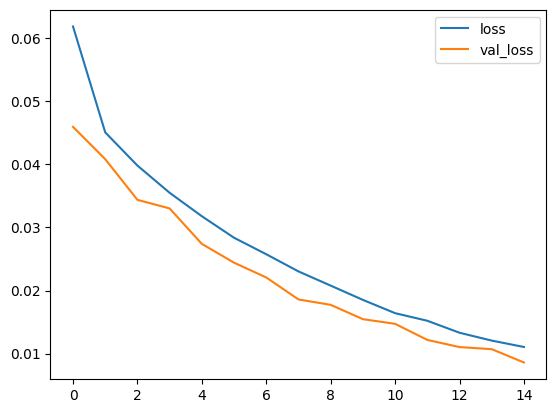

In [26]:
plt.figure(figsize=(10,10))
pd.DataFrame(history.history).plot()
plt.show()

In [27]:
history.history

{'loss': [0.06189029663801193,
  0.045091815292835236,
  0.03982292488217354,
  0.03550432622432709,
  0.031787075102329254,
  0.028373464941978455,
  0.02575642801821232,
  0.023032166063785553,
  0.02077868953347206,
  0.01851479895412922,
  0.01640840247273445,
  0.01520395278930664,
  0.013302410952746868,
  0.012057900428771973,
  0.011042683385312557],
 'val_loss': [0.045963604003190994,
  0.040840033441782,
  0.0343891941010952,
  0.03302094340324402,
  0.0273967906832695,
  0.02441605180501938,
  0.022069502621889114,
  0.01858419179916382,
  0.01772984303534031,
  0.015456321649253368,
  0.014718261547386646,
  0.01216624490916729,
  0.011028487235307693,
  0.010698370635509491,
  0.00858529843389988]}

## 4. Make predictions

In [28]:
input_text = vectorizer('You freaking suck! I am going to hit you.')

In [29]:
res = model.predict(np.expand_dims(input_text,0))

1/1 [==============================] - 1s 1s/step


In [30]:
(res > 0.5).astype(int)

array([[1, 1, 1, 0, 1, 0]])

In [31]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [32]:
(model.predict(batch_X) > 0.5).astype(int)

1/1 [==============================] - 0s 66ms/step


array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [33]:
res.shape

(1, 6)

## 5. Evaluate Model

In [34]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy , F1Score

In [35]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()
f1 = F1Score()

In [37]:
for batch in test.as_numpy_iterator():
    # Unpack the batch
    X_true, y_true = batch
    # Make a prediction
    yhat = model.predict(X_true)

    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()

    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)
    #f1.update_state(y_true , yhat)

1/1 [==============================] - 0s 53ms/step


In [38]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 0.9548659920692444, Recall:0.9543275833129883, Accuracy:0.5060120224952698


## 6. Saving Model

In [ ]:
model.save('comm_anat.h5')